autism image classification with witha  weighted loss for the cars score: people with severe autism will be treated more importantly in our model

In [1]:
import cv2
import os
import math
import json
import gc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from PIL import Image
import numpy as np

from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import precision_score, recall_score,  f1_score
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.preprocessing import StandardScaler


In [2]:
metadata_path = "../dataset/Metadata/data.json"
image_dir = "../dataset/Images/"
input_shape=(224,224)
batch_size=16

In [3]:
def open_image(image_path):
        # Load the image using Pillow
    pil_img = Image.open(image_path).convert("RGB")  # Convert to RGB (if not already)
    img_array = np.array(pil_img)
    return img_array

def show_image(img_array):
    if(img_array.shape[2]== 1):
        plt.imshow(img_array, cmap='gray')
    else:
        plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [4]:
def get_data_labels_and_metadata(dataset):
    """
    Extracts data and labels from a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to extract data and labels from.

    Returns:
        Tuple of (data, labels), where:
        - data is a NumPy array of features.
        - labels is a NumPy array of labels.
    """
    data = []
    labels = []
    metadatas=[]
    dataset = dataset.unbatch()

    for features, label, metadata in dataset:
        data.append(features.numpy())
        labels.append(label.numpy())
        metadatas.append(metadata.numpy())

    # Convert lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)
    metadata = np.array(metadatas)

    return data, labels, metadata


In [5]:
def create_dataset(data, labels, metadata, batch_size=batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from images and labels.

    Args:
        data (list or np.array): List or array of image data.
        labels (list or np.array): Corresponding labels.
        batch_size (int): Batch size for the dataset.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: A TensorFlow dataset.
    """

    dataset = tf.data.Dataset.from_tensor_slices((data, labels, metadata))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [6]:
# One hot encoding
class_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(["TC", "TS"]),
        values=tf.constant([0, 1])  # Map to integers
    ),
    default_value=-1  # Handle unknown values
)

def one_hot_encode(data, label, metadata):
    num_classes = 2  # Adjust this to the actual number of classes
    # Map string labels to integers

    label = class_mapping.lookup(label)
    # Check for unmapped (invalid) labels
    tf.debugging.assert_greater_equal(label, 0, message="Unknown label encountered")

    label = tf.squeeze(label)
    label = tf.one_hot(label, depth=num_classes)

    return data, label, metadata

In [7]:
def load_metadata_json(metadata_path):
    """
    Load metadata from a JSON file.
    Args:
        metadata_path (str): Path to the metadata file (JSON format).
    Returns:
        list: A list of dictionaries with metadata.
    """
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata


def match_metadata_with_images_json(image_dir, metadata, target_size=(100, 100)):
    """
    Match images with their metadata and preprocess the data.
    Args:
        image_dir (str): Path to the directory containing images.
        metadata (dict): Metadata grouped by 'TCImages' and 'TSImages'.
        target_size (tuple): Target size for image resizing.
    Returns:
        np.array, np.array, np.array: Preprocessed images, labels, and metadata features.
    """
    data = []
    labels = []
    metadata_features = []

    # Merge metadata entries from both TCImages and TSImages
    metadata_merged = metadata['TCImages'] + metadata['TSImages']

    for entry in metadata_merged:
        # Extract filename, label, and metadata features
        filename = entry['File']
        # participant_id = entry['ParticipantID']
        # age = float(entry['Age']) if 'Age' in entry and entry['Age'] else np.nan
        # gender = entry['Gender'] if 'Gender' in entry else None
        cars_score = entry['CARS']

        # if(image_dir.find("Unseen")):
        #     if(math.isnan(cars_score)):
        #         label= 

        # # Determine the label
        # if(cars_score==0):
        #     label = "TC"
        # else: 
        #     label = "TS"

        subdir=''
        # Determine the image path
        if "TC" in filename:
            subdir = 'TCImages'
            label='TC'
        elif "TS" in filename:
            subdir = 'TSImages'
            label='TS'
            
        image_path = os.path.join(image_dir, subdir, filename)

        # Preprocess the image if it exists

        if os.path.exists(image_path):

            img_array = open_image(image_path)
            data.append(img_array)

            # Collect label and metadata features
            labels.append(label)
            metadata_features.append(
                #'CARS':
                cars_score
                # 'ParticipantID': participant_id,
                # 'Age': age,
                # 'Gender': gender,
            )
        else:
            print(f"Warning: Image {filename} not found! {image_path}")

    labels = np.array(labels)

    # Convert metadata features to structured NumPy array
    # Encode categorical features (e.g., Gender)
    # metadata_features_array = np.array([

    #         feature['CARS']
    #         # float(feature['ParticipantID']),
    #         # feature['Age'],
    #         # hash(feature['Gender']) if feature['Gender'] is not None else 0

    #     #for feature in metadata_features
    # ]).astype('float32')

    metadata_features_array = np.array(metadata_features)

    metadata_features_array = np.nan_to_num(metadata_features_array, nan=0.0)

    return data, labels, metadata_features_array


In [8]:
def average_laplacian(image):
    """Applies an average filter followed by a Laplacian filter."""
    kernel_size = (3, 3)  # Define kernel size for averaging
    average_filtered = cv2.blur(image, kernel_size)

    # Convert image to float64 for Laplacian
    image = image.astype(np.float64)  # Use np.float64 for the Laplacian filter

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)

    # Enhance the image
    enhanced_image = laplacian_filtered - average_filtered

    # Convert back to uint8 (clip to valid range)
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image


In [9]:
def preprocess_image(img_array,color, target_size):
    """
    Preprocess a batch of images:
    - Convert each image in the batch to grayscale.
    - Resize each image to the target size.
    Args:
        img_array (np.array): Input batch of images (batch_size, H, W, C).
        target_size (tuple): Desired target size (width, height).
    Returns:
        np.array: Preprocessed grayscale images of target size (batch_size, H', W').
    """
    if img_array is None or img_array.size == 0:
        raise ValueError("Input image array is empty or None.")

    # Ensure the input image has the correct shape
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = img_array.squeeze(-1)  # Remove the single channel -> (H, W)

    #laplacian_img = average_laplacian(img_array)  # Apply Laplacian filter

    laplacian_img =cv2.threshold(img_array, 4, 255, cv2.THRESH_BINARY)[1]

    if color is False:
        grayscale_img = cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]
        grayscale_img = cv2.cvtColor(laplacian_img, cv2.COLOR_RGB2GRAY)  # Already grayscale
        grayscale_img = cv2.equalizeHist(grayscale_img)  # Histogram equalization
    else:
      grayscale_img = laplacian_img

    # Ensure input to equalizeHist() is single-channel

    # Resize the image
    resized_img = cv2.resize(laplacian_img, target_size, interpolation=cv2.INTER_AREA)
    #resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)

    # Add back the channel dimension for grayscale images
    # if not color:
    #     resized_img = np.expand_dims(resized_img, axis=-1)  # (H, W, 1)

    return resized_img

def preprocess_dataset(concat_data, concat_labels, target_size, color):
    """
    Processes a MapDataset and prepares the dataset.
    Assumes the dataset yields tuples of (image, label).
    """
    data = []
    labels = []

    for img_array, label in zip(concat_data, concat_labels):
        processed_image = preprocess_image(img_array, color, target_size)
        data.append(processed_image)
        labels.append(label)

    # Convert to NumPy arrays
    labels = np.array(labels)

    # Add a channel dimension for grayscale images (required for CNN input)
    if color==False:
        data = np.expand_dims(data, axis=-1)

    data = np.array(data)
    labels = np.array(labels)

    #processed_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return data, labels


In [10]:
def save_dataset(dataset, dataset_name):
    # Initialize lists to store dataset elements (features, labels)
    features_list = []
    labels_list = []
    metadata_list = []

    # Iterate through the dataset and collect the elements
    for features, labels, metadata in dataset:
        features_list.append(features.numpy())  # Convert tensors to NumPy
        labels_list.append(labels.numpy())
        metadata_list.append(metadata.numpy())

    # Save as .npy files
    np.save(f"{dataset_name}_features.npy", np.array(features_list))
    np.save(f"{dataset_name}_labels.npy", np.array(labels_list))
    np.save(f"{dataset_name}_metadata.npy", np.array(metadata_list))
    print(f"Dataset saved as {dataset_name}_features.npy and {dataset_name}_labels.npy")

def load_dataset(dataset_name):
    # Load the saved NumPy arrays
    features = np.load(f"{dataset_name}_features.npy",allow_pickle=True)
    labels = np.load(f"{dataset_name}_labels.npy",allow_pickle=True)
    metadata = np.load(f"{dataset_name}_metadata.npy",allow_pickle=True)

    # Convert them back to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features)
    labels_tensor = tf.convert_to_tensor(labels)
    metadata_tensor = tf.convert_to_tensor(metadata)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor, metadata_tensor))
    return dataset

In [11]:
# Load the metadata
metadata_list = load_metadata_json(metadata_path)

# Preprocess data and metadata
data, labels, metadata_features = match_metadata_with_images_json(image_dir, metadata_list)

In [12]:
metadata_features.mean()

12.126142595978061

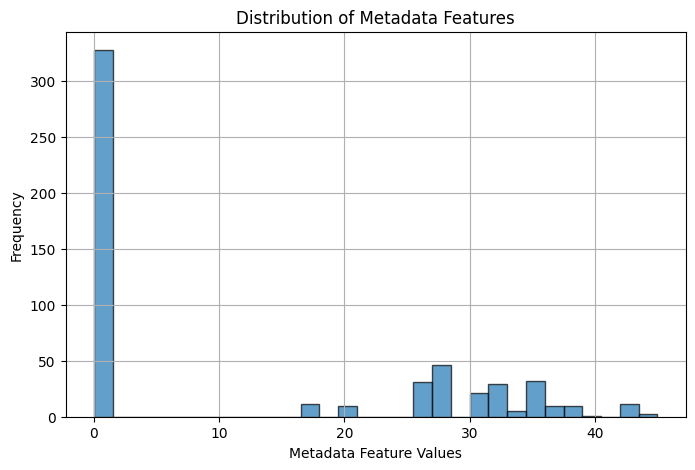

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(metadata_features, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Metadata Feature Values")
plt.ylabel("Frequency")
plt.title("Distribution of Metadata Features")
plt.grid(True)
plt.show()

In [14]:
data, labels = preprocess_dataset(data, labels, target_size=input_shape, color=True)

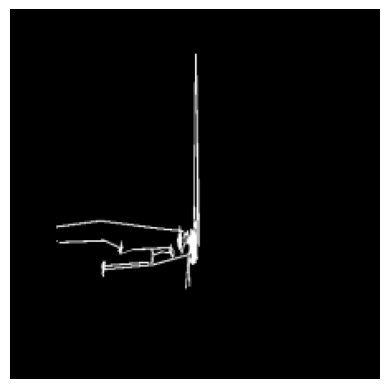

In [15]:
show_image(data[0])

In [16]:
# Define Data Augmentation Pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, interpolation="nearest"),
    layers.RandomZoom(0.1),
])

def augment_multiple_times(data, labels, metadata_features, augmentations=5, batch_size=32):
    """
    Augment images multiple times while keeping metadata aligned.

    Args:
        data (tf.Tensor): Input tensor of images.
        labels (tf.Tensor): Corresponding labels.
        metadata_features (np.array or tf.Tensor): Metadata for each image.
        augmentations (int): Number of augmentations to apply.
        batch_size (int): Number of images to process per batch.

    Returns:
        augmented_images (tf.Tensor): Augmented images.
        augmented_labels (tf.Tensor): Augmented labels.
        augmented_metadata (tf.Tensor): Augmented metadata.
    """
    augmented_images = []
    augmented_labels = []
    augmented_metadata = []

    for i in range(0, data.shape[0], batch_size):

        # Get current batch
        batch_data = data[i:i+batch_size]
        #batch_data = tf.squeeze(batch_data, axis=-1)  # Remove the last channel
        batch_labels = labels[i:i+batch_size]
        batch_metadata = metadata_features[i:i+batch_size]

        # Augment the current batch
        for _ in range(augmentations):
            augmented_images.append(data_augmentation(batch_data))
            augmented_labels.append(batch_labels)
            augmented_metadata.append(batch_metadata)  # Duplicate metadata for each augmentation

    # Convert to tensors
    augmented_images = tf.concat(augmented_images, axis=0)
    augmented_labels = tf.concat(augmented_labels, axis=0)
    augmented_metadata = tf.concat(augmented_metadata, axis=0)

    return augmented_images, augmented_labels, augmented_metadata


In [18]:
with tf.device('/CPU:0'):
    augmented_data, augmented_labels, augmented_metadata = augment_multiple_times(data, labels, metadata_features, augmentations=10, batch_size=batch_size)

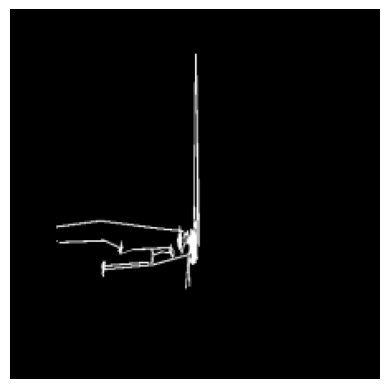

In [ ]:
show_image(data[0])

In [ ]:
# Instead of combining original and augmented images:
# combined_data = augmented_data
# combined_labels = augmented_labels
# combined_metadata = augmented_metadata

In [19]:
combined_data = np.concatenate((data, augmented_data), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)
combined_metadata = np.concatenate((metadata_features, augmented_metadata), axis=0)

In [ ]:
#with tf.device('/CPU:0'):
pre_pca_combined = create_dataset(combined_data, combined_labels, combined_metadata)

In [20]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Example Tensor of string labels
tensor_data = tf.constant(combined_labels, dtype=tf.string)

# Convert the tensor to a list of strings
strings = tensor_data.numpy().astype(str)

# Reshape the data to match the expected input shape for OneHotEncoder
strings_reshaped = np.array(strings).reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the data
combined_labels = encoder.fit_transform(strings_reshaped)


In [22]:
# with tf.device('/CPU:0'):
#     save_dataset(pre_pca_combined, "autism2_dataset")

In [23]:
#pre_pca_combined= load_dataset("autism2_dataset")

In [24]:
gc.collect()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


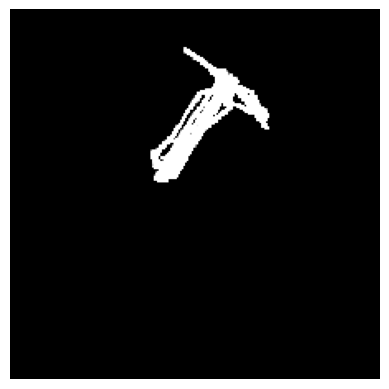

In [22]:
with tf.device('/CPU:0'):
    show_image(combined_data[1000])

In [50]:
combined_data = combined_data.numpy()  # Convert to numpy array
combined_labels = combined_labels.numpy()  # Convert to numpy array
combined_metadata = combined_metadata.numpy()  # Convert to numpy array

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [56]:
gc.collect()

2744

In [25]:
from sklearn.model_selection import train_test_split

with tf.device('/CPU:0'):
    train_data, test_data, train_labels, test_labels, train_metadata, test_metadata = train_test_split(
        combined_data, 
        combined_labels, 
        combined_metadata, 
        test_size=0.2,  # Adjust the test size as needed (e.g., 20% test data)
        random_state=42,

    )

    train_data, validation_data, train_labels, validation_labels, train_metadata, validation_metadata = train_test_split(
        train_data, 
        train_labels, 
        train_metadata, 
        test_size=0.2,  # Adjust the test size as needed (e.g., 20% test data)
        random_state=42,  # Optional: For reproducibility
    )

In [ ]:
# with tf.device('/CPU:0'):
#     train_dataset, test_dataset = tf.keras.utils.split_dataset(
#         pre_pca_combined,
#         left_size=0.8,
#         shuffle=True,
#         seed=42,
#         #stratify=y_labels
#     )

#     train_dataset, val_dataset = tf.keras.utils.split_dataset(
#         train_dataset,
#         left_size=0.8,
#         shuffle=True,
#         seed=42
#     )

AttributeError: module 'keras.api._v2.keras.utils' has no attribute 'split_dataset'

In [36]:
with tf.device('/CPU:0'):
    train_dataset = create_dataset(train_data, train_labels, train_metadata)

    test_dataset = create_dataset(test_data, test_labels, test_metadata)

    val_dataset = create_dataset(validation_data, validation_labels, validation_metadata)

In [40]:
combined_labels

array([0, 0, 1, ..., 1, 0, 0])

In [39]:
train_labels

array([0, 0, 1, ..., 1, 1, 1])

In [37]:
train_dataset = train_dataset.map(one_hot_encode)

val_dataset= val_dataset.map(one_hot_encode)

test_dataset= test_dataset.map(one_hot_encode)

TypeError: in user code:

    File "C:\Users\Alex\AppData\Local\Temp\ipykernel_11076\2762546637.py", line 14, in one_hot_encode  *
        label = class_mapping.lookup(label)

    TypeError: Dtype of argument `keys` must be <dtype: 'string'>, received: <dtype: 'int32'>


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification.
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- Weighting factor for class imbalance.
        gamma -- Focusing parameter for modulating factor (1-p).
    """
    @tf.function
    def focal_loss(y_true, y_pred, sample_weight=None):  # Add sample_weight as an argument

        y_true = tf.cast(y_true, tf.float32)

        # Define epsilon to avoid NaN in backpropagation
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate the cross entropy (log loss)
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate weight, which combines alpha and the focusing factor (1-p)^gamma
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Compute focal loss
        loss = weight * cross_entropy

        # Sum the losses in the batch
        loss = K.sum(loss, axis=1)

        # If sample_weight is provided, multiply it by the loss
        if sample_weight is not None:
            loss = loss * sample_weight  # Apply sample weights

        return loss
    
    return focal_loss

# class CategoricalFocalLoss(Loss):
#     def __init__(self, gamma=2.0, alpha=0.25, name="categorical_focal_loss"):
#         super().__init__(name=name)
#         self.gamma = gamma
#         self.alpha = alpha

#     def call(self, y_true, y_pred):
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

#         cross_entropy = -y_true * K.log(y_pred)
#         weight = self.alpha * y_true * K.pow((1 - y_pred), self.gamma)
#         loss = weight * cross_entropy

#         # if sample_weight is not None:
#         #     loss = loss * sample_weight  # Apply sample weights

#         return loss
#         #return K.sum(loss, axis=1)
    
#     def get_config(self):  # Required for saving the model
#         return {"gamma": self.gamma, "alpha": self.alpha}
    
#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)


def create_efficient_model():
    # Load EfficientNet model pretrained on ImageNet
    efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    efficientnet_base.trainable = False  # Freeze EfficientNet layers

    for layer in efficientnet_base.layers[-10:]:
        layer.trainable = True

    # Input for image data
    image_input = Input(shape=(224, 224, 3), name='image_input')

    # Feature extraction
    x = efficientnet_base(image_input)
    x = GlobalAveragePooling2D()(x)  # Convert to feature vector

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Output layer (Binary classification)
    output = Dense(2, activation='softmax')(x)

    # Create model
    model = Model(inputs=image_input, outputs=output)

    # Compile model (we pass focal loss dynamically during training)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  #loss='categorical_crossentropy',
                  #loss = SigmoidFocalCrossEntropy()
                  #loss = tf.keras.losses.CategoricalFocalCrossentropy(),
                  #loss=FocalLoss(),
                  #loss=lambda y_true, y_pred: custom_focal_loss(alpha=0.25, gamma=2.0),
                  #loss='categorical_focal_crossentropy',
                  #loss='binary_focal_crossentropy',
                  loss=categorical_focal_loss(),
                    metrics=['accuracy'])

    return model

In [107]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Concatenate)
from tensorflow.keras.regularizers import l2

def feature_extractor_cnn(input_shapes):
    image_input_shape, metadata_input_shape = input_shapes
    
    # Image input branch
    image_input = Input(shape=image_input_shape)
    x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01))(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = Dropout(rate=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    
    # Metadata input branch
    metadata_input = Input(shape=metadata_input_shape)
    
    # Concatenate image and metadata features
    merged = Concatenate()([x, metadata_input])
    
    model = Model(inputs=[image_input, metadata_input], outputs=merged)
    
    return model


In [108]:
# Example usage: Assuming input images are grayscale 100x100
input_shape = ((224, 224, 3),(1,))
cnn_feature_extractor = feature_extractor_cnn(input_shape)

In [111]:
def create_model_cnn(feature_extractor):
    # Get inputs from feature_extractor
    image_input, metadata_input = feature_extractor.input
    feature_output = feature_extractor.output

    # Fully connected layers
    x = Dense(64, activation='relu')(feature_output)
    x = Dense(2, activation='softmax')(x)

    # Define the final model with both inputs
    model = Model(inputs=[image_input, metadata_input], outputs=x)
    
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])
    
    return model


In [121]:
model_cnn = create_model_cnn(cnn_feature_extractor)

# 3. Compile the model
model_cnn.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 224, 224, 16  1216        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 112, 112, 16  0          ['conv2d_4[0][0]']               
                                )                                                           

In [125]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history_cnn = model_cnn.fit([train_data, train_metadata], train_labels, batch_size=batch_size, epochs=20, validation_data=([validation_data, validation_metadata], validation_labels),callbacks=[early_stopping])

Epoch 1/20
107/107 [==============================] - 59s 541ms/step - loss: 1.3727 - accuracy: 0.6793 - val_loss: 1.3445 - val_accuracy: 0.7292
Epoch 2/20
107/107 [==============================] - 16s 145ms/step - loss: 1.2618 - accuracy: 0.7669 - val_loss: 1.2970 - val_accuracy: 0.7546
Epoch 3/20
107/107 [==============================] - 16s 146ms/step - loss: 1.1959 - accuracy: 0.7979 - val_loss: 1.2728 - val_accuracy: 0.7755
Epoch 4/20
107/107 [==============================] - 16s 148ms/step - loss: 1.1609 - accuracy: 0.8148 - val_loss: 1.2523 - val_accuracy: 0.7685
Epoch 5/20
107/107 [==============================] - 15s 144ms/step - loss: 1.1117 - accuracy: 0.8446 - val_loss: 1.2646 - val_accuracy: 0.7593
Epoch 6/20
107/107 [==============================] - 16s 146ms/step - loss: 1.0692 - accuracy: 0.8616 - val_loss: 1.2404 - val_accuracy: 0.7477
Epoch 7/20
107/107 [==============================] - 15s 145ms/step - loss: 1.0404 - accuracy: 0.8797 - val_loss: 1.2332 - val_ac

In [129]:
# Assuming you have test data: X_test_image (test images) and X_test_cars (CARS scores for test)
# And the true labels for test data: y_test
with tf.device('/CPU:0'):
    #test_loss, test_accuracy = model.evaluate([test_data, test_metadata], test_labels)
    y_pred = model_cnn.predict([unseen_data, unseen_metadata])



1/1 [==============================] - 1s 911ms/step


In [132]:
y_pred = np.argmax(y_pred,axis=1)

In [133]:
accuracy_score(y_pred, unseen_labels_1)

0.9

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [43]:
train_data, train_labels, train_metadata = get_data_labels_and_metadata(train_dataset)

In [44]:
validation_data, validation_labels, validation_metadata = get_data_labels_and_metadata(val_dataset)

In [28]:
#train_labels = np.argmax(train_labels, axis=1)

scaler = StandardScaler()
train_metadata = scaler.fit_transform(train_metadata.reshape(-1, 1)).flatten()

In [29]:
#validation_labels = np.argmax(validation_labels, axis=1)

validation_metadata = scaler.transform(validation_metadata.reshape(-1, 1)).flatten()

In [29]:
model = create_efficient_model()

In [30]:
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

In [31]:
reset_weights(model)

In [67]:
num_epochs = 10  # Set number of epochs

for epoch in range(num_epochs):
    epoch_loss = 0
    train_accuracy.reset_states()  # Reset accuracy at the start of each epoch

    for batch_images, batch_labels, batch_cars_scores in train_dataset:
        loss = train_step(batch_images, batch_labels, batch_cars_scores)
        epoch_loss += loss.numpy()
    
    # Print loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy.result().numpy():.4f}")


Epoch 1/10, Loss: 6161.0048, Accuracy: 0.5671
Epoch 2/10, Loss: 5375.2080, Accuracy: 0.7139
Epoch 3/10, Loss: 5021.6027, Accuracy: 0.7454
Epoch 4/10, Loss: 4892.0218, Accuracy: 0.7431
Epoch 5/10, Loss: 4765.2960, Accuracy: 0.7483
Epoch 6/10, Loss: 4712.4300, Accuracy: 0.7477
Epoch 7/10, Loss: 4643.0626, Accuracy: 0.7494


KeyboardInterrupt: 

In [ ]:
#train_labels = np.argmax(train_labels, axis=1)

train_metadata = np.reshape(train_metadata, (1744,))


AxisError: axis 1 is out of bounds for array of dimension 1

In [32]:
max_cars_score = 60
train_metadata = tf.cast(train_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]

train_metadata = tf.constant(1, dtype=float) + train_metadata
# for i in range(len(train_metadata)):
#     train_metadata[i] = 1.0 + train_metadata[i]  # Rescale to [1, 2]

In [42]:
for i in range(len(train_metadata)):
    print(train_metadata[i])

tf.Tensor(1.0032117, shape=(), dtype=float32)
tf.Tensor(1.0035408, shape=(), dtype=float32)
tf.Tensor(1.0043402, shape=(), dtype=float32)
tf.Tensor(1.0031565, shape=(), dtype=float32)
tf.Tensor(1.0029137, shape=(), dtype=float32)
tf.Tensor(1.0010256, shape=(), dtype=float32)
tf.Tensor(1.0050701, shape=(), dtype=float32)
tf.Tensor(1.0042646, shape=(), dtype=float32)
tf.Tensor(1.0027716, shape=(), dtype=float32)
tf.Tensor(1.0055555, shape=(), dtype=float32)
tf.Tensor(1.0129908, shape=(), dtype=float32)
tf.Tensor(1.0105293, shape=(), dtype=float32)
tf.Tensor(1.0162504, shape=(), dtype=float32)
tf.Tensor(1.0134482, shape=(), dtype=float32)
tf.Tensor(1.0153122, shape=(), dtype=float32)
tf.Tensor(1.0133154, shape=(), dtype=float32)
tf.Tensor(1.0038525, shape=(), dtype=float32)
tf.Tensor(1.0064635, shape=(), dtype=float32)
tf.Tensor(1.0026242, shape=(), dtype=float32)
tf.Tensor(1.0156894, shape=(), dtype=float32)
tf.Tensor(1.0038515, shape=(), dtype=float32)
tf.Tensor(1.0111676, shape=(), dty

In [35]:
gc.collect()

1484

In [38]:
train_data = tf.convert_to_tensor(train_data)
test_data = tf.convert_to_tensor(test_data)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)
train_metadata = tf.convert_to_tensor(train_metadata)
test_metadata = tf.convert_to_tensor(test_metadata)


In [36]:
with tf.device('/CPU:0'):
    history = model.fit(
        train_data,
        train_labels,
        epochs=15,
        sample_weight=train_metadata,
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping, reduce_lr],
        batch_size=32
    )

Epoch 1/15
121/121 [==============================] - 171s 1s/step - loss: 0.0377 - accuracy: 0.7551 - val_loss: 0.0291 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 2/15
121/121 [==============================] - 170s 1s/step - loss: 0.0293 - accuracy: 0.8203 - val_loss: 0.0258 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 3/15
121/121 [==============================] - 165s 1s/step - loss: 0.0235 - accuracy: 0.8673 - val_loss: 0.0217 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 4/15
121/121 [==============================] - 162s 1s/step - loss: 0.0198 - accuracy: 0.8943 - val_loss: 0.0219 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 5/15
121/121 [==============================] - 161s 1s/step - loss: 0.0170 - accuracy: 0.9138 - val_loss: 0.0197 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 6/15
121/121 [==============================] - 163s 1s/step - loss: 0.0135 - accuracy: 0.9312 - val_loss: 0.0166 - val_accuracy: 0.8930 - lr: 0.0010
Epoch 7/15
121/121 [==============================] - 176s 1s/st

In [41]:
model.save_weights("./weights/autism2-93")

In [56]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

# Register your loss function as a custom object
get_custom_objects().update({"categorical_focal_loss": categorical_focal_loss()})

# Save the model
model.save("efficient_80", save_format="h5")

# Load the model with the custom loss
model = load_model("efficient_80.h5", custom_objects={"categorical_focal_loss": categorical_focal_loss()})


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [40]:
model.save('efficient_93.h5')

In [39]:
metadata_features.mean(), np.array(combined_metadata).mean()

(12.042830540037244, 12.042830540037244)

In [34]:
test_data, test_labels, test_metadata = get_data_labels_and_metadata(test_dataset)

In [37]:
test_metadata.fill(1)

In [ ]:
# test_metadata = tf.cast(test_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]
# test_metadata = 1.0 + test_metadata  # Rescale to [1, 2]

In [40]:
test_metadata

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [38]:
y_pred=model.predict(test_data)

38/38 [==============================] - 11s 77ms/step


In [39]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9336


In [51]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

recall_score(y_true_labels, y_pred_labels), precision_score(y_true_labels, y_pred_labels) ,f1_score(y_true_labels, y_pred_labels)

(0.9342723004694836, 0.9277389277389277, 0.9309941520467836)

In [53]:
y_pred

array([[0.9171671 , 0.08283283],
       [0.04770298, 0.952297  ],
       [0.342376  , 0.65762395],
       ...,
       [0.66946113, 0.33053884],
       [0.9306895 , 0.06931043],
       [0.95046884, 0.04953112]], dtype=float32)

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
cm

array([[631,  28],
       [ 31, 398]], dtype=int64)

In [59]:
test_labels = np.argmax(test_labels, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [60]:
y_pred =  np.argmax(y_pred, axis=1)

In [63]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(test_labels, y_pred)

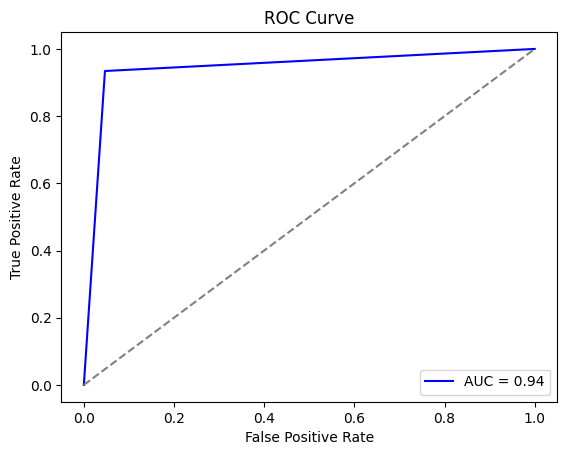

In [64]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()